In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from trade_flow_modelling.src.data_management.sign_extractor import sign_extractor

from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm
from scipy import linalg
import multiprocessing
import time_test
import os
from statsmodels.tools.tools import pinv_extended
import psutil
from joblib import Parallel, delayed
from modelisation.regression import linear_models

def set_thread_env_var(nb_threads=1):
    os.environ["OMP_NUM_THREADS"] = str(nb_threads)
    os.environ["OPENBLAS_NUM_THREADS"] = str(nb_threads)
    os.environ["MKL_NUM_THREADS"] = str(nb_threads)
    os.environ["VECLIB_MAXIMUM_THREADS"] = str(nb_threads)
    os.environ["NUMEXPR_NUM_THREADS"] = str(nb_threads)

def remove_thread_env_var():
    os.environ.pop("OMP_NUM_THREADS", None)
    os.environ.pop("OPENBLAS_NUM_THREADS", None)
    os.environ.pop("MKL_NUM_THREADS", None)
    os.environ.pop("VECLIB_MAXIMUM_THREADS", None)
    os.environ.pop("NUMEXPR_NUM_THREADS", None)

def cpu_last_minute():
    return f"[cpu: {round(100 * psutil.getloadavg()[0] / psutil.cpu_count(), 2)} % last minute]"

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':  # for integers
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:  # for floats.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
%matplotlib inline

PYSPARK_UTILS
DATES_UTILS
DATES TYPES
DATA_LOADER
SYMBOLS


In [2]:
signs = sign_extractor.retrieve_signs("APTUSDT", f"2023-11-14", f"2023-11-17")
print(len(signs))

def compute_x_pd(signs, max_lag):
    x, y = lagmat(signs, max_lag, original="sep")
    x = sm.add_constant(x)
    y = y[max_lag:]
    x = x[max_lag:]
    x_pd = pd.DataFrame(x)
    x_pd_reduced = reduce_mem_usage(x_pd, False)
    return x_pd_reduced, y

max_lag = 60


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/02 11:19:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=23326Kb max_used=23403Kb free=107745Kb
 bounds [0x00000001061e0000, 0x00000001078f0000, 0x000000010e1e0000]
 total_blobs=9601 nmethods=8672 adapters=840
 compilation: disabled (not enough contiguous free space left)


368448


Lags: 57 | Total time: 18.14 s (in loops: 17.6 s) (avg time per loop: 0.2885 s) [cpu: 59.86 % last minute]


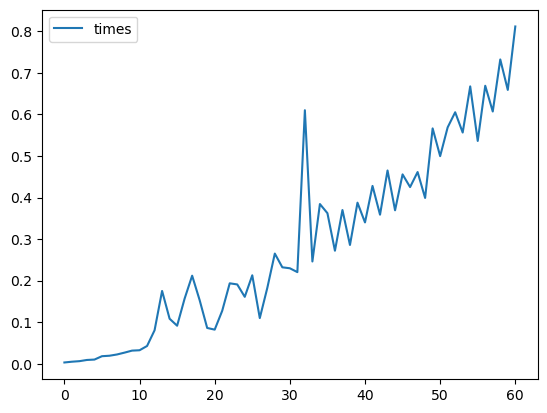

In [156]:
# V1
remove_thread_env_var()
importlib.reload(time_test)
start = time.time()
times = []
x_pd, y = compute_x_pd(signs[:100000], max_lag)

ics = []
for i in range(max_lag + 1):
    res, time_loop = time_test.f_1_loop(x_pd, y, i + 1)
    ics.append(res)
    times.append(time_loop)

selected_tuple = min(ics, key=lambda x: x[1])
selected_lags = selected_tuple[0]

end = time.time()
print(f"Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}")
plt.plot(times, label="times")
# x = [i for i in range(0, len(times) + 1)]
# plt.plot(x, [0.0018 * i for i in x], label="x")
# plt.plot(x, [0.0001 * i * i for i in x], label="x*x")
plt.legend()
plt.show()

In [138]:
# V2 (pool with apply)
importlib.reload(time_test)
remove_thread_env_var()

def v2(nb_processes):
    start = time.time()
    times = []
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    pool = multiprocessing.Pool(nb_processes, initializer=time_test.init_worker, initargs=(x_pd, y))
    outputs = [pool.apply(time_test.f_1_loop_bis, (i + 1,)) for i in range(max_lag + 1)]
    assert(len(outputs) == max_lag + 1)

    ics = []
    for res, time_loop in outputs:
        ics.append(res)
        times.append(time_loop)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_processes} processes => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s  / {nb_processes} => {round(sum(times) / nb_processes, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}")
    # plt.plot(times)

for nb_processes in [1, 2, 8]:
    v2(nb_processes)

1 processes => Lags: 57 | Total time: 24.06 s (in loops: 22.68 s  / 1 => 22.68) (avg time per loop: 0.3719 s) [cpu: 171.07 % last minute]
2 processes => Lags: 57 | Total time: 24.41 s (in loops: 21.6 s  / 2 => 10.8) (avg time per loop: 0.3541 s) [cpu: 246.19 % last minute]
8 processes => Lags: 57 | Total time: 23.69 s (in loops: 18.58 s  / 8 => 2.32) (avg time per loop: 0.3045 s) [cpu: 225.78 % last minute]


In [7]:
# V2 (pool with map)
importlib.reload(time_test)
remove_thread_env_var()

def v3(nb_processes):
    start = time.time()
    times = []
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    pool = multiprocessing.Pool(nb_processes, initializer=time_test.init_worker, initargs=(x_pd, y))
    outputs = pool.map(time_test.f_1_loop_bis, [i + 1 for i in range(max_lag + 1)])
    assert(len(outputs) == max_lag + 1)

    ics = []
    for res, time_loop in outputs:
        ics.append(res)
        times.append(time_loop)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_processes} processes => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s  / {nb_processes} => {round(sum(times) / nb_processes, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}")
    # plt.plot(times)

for nb_processes in [1, 2, 8]:
    v3(nb_processes)

1 processes => Lags: 57 | Total time: 17.23 s (in loops: 16.01 s  / 1 => 16.01) (avg time per loop: 0.2624 s) [cpu: 74.88 % last minute]
2 processes => Lags: 57 | Total time: 54.38 s (in loops: 103.67 s  / 2 => 51.83) (avg time per loop: 1.6995 s) [cpu: 233.69 % last minute]
8 processes => Lags: 57 | Total time: 80.61 s (in loops: 547.79 s  / 8 => 68.47) (avg time per loop: 8.9802 s) [cpu: 971.42 % last minute]


In [13]:
def dispatch_indices(max_lag, nb_processes):
    args = [[] for _ in range(nb_processes)]
    direction = True
    for i in range(max_lag + 1):
        args_idx = i % nb_processes
        new_args_idx = args_idx if direction else nb_processes - 1 - args_idx
        direction = direction if args_idx != nb_processes - 1 else not(direction)
        args[new_args_idx].append(i + 1)
    assert(sum([len(l) for l in args]) == max_lag + 1)
    return args

In [14]:
# V4
importlib.reload(time_test)
remove_thread_env_var()
def v4(nb_processes):
    # fig, axe = plt.subplots(1, 1, figsize=(6, 3))
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)
    processes = []
    args = dispatch_indices(max_lag, nb_processes)

    for i in range(nb_processes):
        p = time_test.Process1(x_pd, y, args[i])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        # all_res = [p.res.get() for _ in range(len(p.indices))]

    times = []
    ics = []
    for i, p in enumerate(processes):
        current_process_times = [p.times_process.get() for _ in range(len(p.indices))]
        current_process_res = [p.res_process.get() for _ in range(len(p.indices))]
        times.extend(current_process_times)
        ics.extend(current_process_res)
        # axe.plot(current_process_times, label=f"{i + 1} (avg: {round(np.mean(times), 2)} s)")

    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_processes} processes => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_processes} => {round(sum(times) / nb_processes, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}")

    # plt.legend()
    # plt.plot()


for nb_processes in [1, 2, 8]:
    v4(nb_processes)

1 processes => Lags: 57 | Total time: 17.3 s (in loops: 15.94 s / 1 => 15.94) (avg time per loop: 0.2612 s) [cpu: 89.42 % last minute]
2 processes => Lags: 57 | Total time: 54.54 s (in loops: 104.52 s / 2 => 52.26) (avg time per loop: 1.7134 s) [cpu: 184.24 % last minute]
8 processes => Lags: 57 | Total time: 73.71 s (in loops: 402.41 s / 8 => 50.3) (avg time per loop: 6.5969 s) [cpu: 679.46 % last minute]


In [136]:
# V5
def v5(nb_processes):
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    def compute_func_for_each_core(indice, idx):
        """ Work done by each core, specified by this function and the input """
        print(f"PROCESS {idx + 1} started {time.time() - start} s after start")
        results = []
        times = []
        for i in indice:
            res, time_loop = time_test.f_1_loop(x_pd, y, i)
            results.append(res)
            times.append(time_loop)

        print(f"TIME process {idx + 1}: {round(sum(times), 2)}")
        return results, times

    args = dispatch_indices(max_lag, nb_processes)
    joblib_rets = Parallel(n_jobs=nb_processes)(
            delayed(compute_func_for_each_core)(arg, idx) for idx, arg in enumerate(args)
        )

    ics = []
    times = []
    for (results, process_times) in joblib_rets:
        times.extend(process_times)
        ics.extend(results)
    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_processes} processes => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_processes} => {round(sum(times) / nb_processes, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}\n")

# for nb_processes in sorted([1, 2, 4, 8, 10], reverse=True):
#     time.sleep(2)
#     v5(nb_processes)


PROCESS 3 started 1.71476411819458 s after start
PROCESS 1 started 1.7148230075836182 s after start
PROCESS 2 started 1.7150499820709229 s after start
PROCESS 4 started 1.7410800457000732 s after start
PROCESS 5 started 1.8416121006011963 s after start
PROCESS 6 started 1.8507821559906006 s after start
PROCESS 8 started 1.9567959308624268 s after start
PROCESS 7 started 1.983431100845337 s after start
TIME process 1: 7.95
TIME process 3: 8.13
TIME process 2: 8.45
TIME process 5: 10.11
TIME process 8: 10.57
TIME process 4: 10.81
TIME process 6: 10.78
TIME process 7: 10.55
8 processes => Lags: 57 | Total time: 12.82 s (in loops: 77.36 s / 8 => 9.67) (avg time per loop: 1.2682 s) [cpu: 140.09 % last minute]



In [16]:
# Multithreading V6

import threading
importlib.reload(time_test)

def v6(nb_threads):
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    ics = []
    times = []

    def f_1_loop(idx_slice):
        s_loop = time.perf_counter()
        x_selection = x_pd.values[:, slice(idx_slice)]

        ols_model = linear_models.OLS(y, x_selection)
        ols_model.df_model = x_selection.shape[1] - 1
        ols_model.k_constant = 1

        res = ols_model.fit()
        
        lags = tuple(j for j in range(1, idx_slice))
        lags = 0 if not lags else lags
        e_loop = time.perf_counter()
        return (lags, res.info_criteria("aic")), e_loop - s_loop

    def compute_func_for_each_core(indice):
        """ Work done by each core, specified by this function and the input """
        for i in indice:
            # print(f"    {i} ({threading.current_thread().ident})")
            res, time_loop = f_1_loop(i)
            ics.append(res)
            times.append(time_loop)

    args = dispatch_indices(max_lag, nb_threads)

    threads = []
    for i in range(nb_threads):
        thread = threading.Thread(target=compute_func_for_each_core, args=[args[i]])
        thread.start()
        threads.append(thread)

    waited_times = []
    for i, thread in enumerate(threads):
        s = time.time()
        thread.join()
        e = time.time()
        waited_times.append(e - s)
    print(f"    Waited in total {round(sum(waited_times[1:]), 2)} s ({waited_times})")

    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_threads} threads => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_threads} => {round(sum(times) / nb_threads, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}")

for nb_threads in [1, 2, 8, 16, 32, 64]:
    v6(nb_threads)

    Waited in total 0 s ([20.465603828430176])
1 threads => Lags: 57 | Total time: 20.64 s (in loops: 20.15 s / 1 => 20.15) (avg time per loop: 0.3304 s) [cpu: 168.5 % last minute]
    Waited in total 0.0 s ([24.296216011047363, 1.0013580322265625e-05])
2 threads => Lags: 57 | Total time: 24.59 s (in loops: 45.74 s / 2 => 22.87) (avg time per loop: 0.7498 s) [cpu: 168.2 % last minute]
    Waited in total 3.03 s ([13.765258073806763, 1.5974044799804688e-05, 4.0531158447265625e-06, 2.1267340183258057, 0.9007120132446289, 2.5033950805664062e-05, 3.814697265625e-06, 4.0531158447265625e-06])
8 threads => Lags: 57 | Total time: 17.08 s (in loops: 96.29 s / 8 => 12.04) (avg time per loop: 1.5786 s) [cpu: 157.55 % last minute]
    Waited in total 11.42 s ([4.343788146972656, 1.4872329235076904, 8.344650268554688e-06, 8.248759746551514, 1.8358230590820312e-05, 3.814697265625e-06, 3.0994415283203125e-06, 2.86102294921875e-06, 0.5222659111022949, 0.04254007339477539, 8.106231689453125e-06, 1.0664

In [80]:
importlib.reload(time_test)

def v7(nb_threads):
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    ics = []
    times = []
    def compute_func_for_each_core(indice):
        """ Work done by each core, specified by this function and the input """
        assert(len(indice) == 1)
        for i in indice:
            # print(f"    {i} ({threading.current_thread().ident})")
            res, time_loop = time_test.f_1_loop(x_pd, y, i)
            ics.append(res)
            times.append(time_loop)

    threads = []
    for i in range(0, min(nb_threads, max_lag + 1)):
        thread = threading.Thread(target=compute_func_for_each_core, args=[[i + 1]])
        thread.start()
        threads.append(thread)

    next_slice = nb_threads + 1
    while (next_slice <= max_lag + 1):
        for i in range(len(threads)):
            if (next_slice > max_lag + 1):
                break
            if (not threads[i].is_alive()):
                threads[i] = None
                new_thread = threading.Thread(target=compute_func_for_each_core, args=[[next_slice]])

                next_slice += 1
                new_thread.start()
                threads[i] = new_thread

    waited_times = []
    for i, thread in enumerate(threads):
        s = time.time()
        thread.join()
        e = time.time()
        waited_times.append(round(e - s, 2))
    print(f"    Waited in total {round(sum(waited_times[1:]), 2)} s ({waited_times})")

    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_threads} threads => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_threads} => {round(sum(times) / nb_threads, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}\n")

for nb_threads in [1, 2, 8, 64]:
    v7(nb_threads)

    Waited in total 0 s ([0.95])
1 threads => Lags: 57 | Total time: 20.77 s (in loops: 19.61 s / 1 => 19.61) (avg time per loop: 0.3214 s) [cpu: 70.41 % last minute]

    Waited in total 0.0 s ([0.77, 0.0])
2 threads => Lags: 57 | Total time: 18.42 s (in loops: 33.0 s / 2 => 16.5) (avg time per loop: 0.541 s) [cpu: 88.92 % last minute]

    Waited in total 0.12 s ([2.06, 0.0, 0.09, 0.0, 0.0, 0.0, 0.03, 0.0])
8 threads => Lags: 57 | Total time: 17.0 s (in loops: 105.82 s / 8 => 13.23) (avg time per loop: 1.7348 s) [cpu: 95.21 % last minute]

    Waited in total 7.23 s ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0])
64 threads => Lags: 57 | Total time: 16.78 s (in loops: 237.76 s / 64 => 3.71) (avg time per loop: 3.8977 s) [cpu:

In [83]:
importlib.reload(time_test)

def v8(nb_threads):
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    ics = []
    times = []
    def compute_func_for_each_core(indice):
        """ Work done by each core, specified by this function and the input """
        assert(len(indice) == 1)
        for i in indice:
            # print(f"    {i} ({threading.current_thread().ident})")
            res, time_loop = time_test.f_1_loop(x_pd, y, i)
            ics.append(res)
            times.append(time_loop)

    # args = dispatch_indices(max_lag, nb_threads)

    threads = []
    for i in range(max_lag + 1, max(max_lag + 1 - nb_threads, 0), -1):
        thread = threading.Thread(target=compute_func_for_each_core, args=[[i]])
        thread.start()
        threads.append(thread)

    assert(len(threads) == nb_threads or len(threads) == max_lag + 1)

    next_slice = max_lag + 1 - nb_threads
    while (next_slice >= 1):
        for i in range(len(threads)):
            if (next_slice < 1):
                break
            if (not threads[i].is_alive()):
                threads[i] = None
                new_thread = threading.Thread(target=compute_func_for_each_core, args=[[next_slice]])

                next_slice -= 1
                new_thread.start()
                threads[i] = new_thread

    waited_times = []
    for i, thread in enumerate(threads):
        s = time.time()
        thread.join()
        e = time.time()
        waited_times.append(round(e - s, 2))
    print(f"    Waited in total {round(sum(waited_times[1:]), 2)} s ({waited_times})")

    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_threads} threads => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_threads} => {round(sum(times) / nb_threads, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}\n")

for nb_threads in [1, 2, 6, 8, 64]:
    v8(nb_threads)


    Waited in total 0 s ([0.01])
1 threads => Lags: 57 | Total time: 17.25 s (in loops: 15.87 s / 1 => 15.87) (avg time per loop: 0.2602 s) [cpu: 64.07 % last minute]

    Waited in total 0.0 s ([0.01, 0.0])
2 threads => Lags: 57 | Total time: 18.34 s (in loops: 33.25 s / 2 => 16.62) (avg time per loop: 0.5451 s) [cpu: 81.02 % last minute]

    Waited in total 0.01 s ([0.03, 0.0, 0.01, 0.0, 0.0, 0.0])
6 threads => Lags: 57 | Total time: 17.54 s (in loops: 91.94 s / 6 => 15.32) (avg time per loop: 1.5073 s) [cpu: 106.97 % last minute]

    Waited in total 0.0 s ([0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
8 threads => Lags: 57 | Total time: 17.18 s (in loops: 115.33 s / 8 => 14.42) (avg time per loop: 1.8906 s) [cpu: 110.18 % last minute]

    Waited in total 0.26 s ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.01, 0.0, 0

In [115]:
# ThreadPool
from concurrent.futures import ThreadPoolExecutor

def v9(nb_threads):
    start = time.time()
    x_pd, y = compute_x_pd(signs[:100000], max_lag)

    ics = []
    times = []
    def compute_func_for_each_core(indice):
        """ Work done by each core, specified by this function and the input """
        assert(type(indice) == int)
        res, time_loop = time_test.f_1_loop(x_pd, y, indice)
        ics.append(res)
        times.append(time_loop)
        # return res, time_loop
        
    executor = ThreadPoolExecutor(max_workers=nb_threads)
    executor.map(compute_func_for_each_core, list(range(max_lag + 1, 0, -1)))
    # executor.map(compute_func_for_each_core, list(range(1, max_lag + 2)))
    executor.shutdown()

    assert(len(ics) == max_lag + 1)

    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]

    end = time.time()
    print(f"{nb_threads} threads => Lags: {len(selected_lags)} | Total time: {round(end - start, 2)} s (in loops: {round(sum(times), 2)} s / {nb_threads} => {round(sum(times) / nb_threads, 2)}) (avg time per loop: {round(np.mean(times), 4)} s) {cpu_last_minute()}\n")

for nb_threads in [1, 2, 8, 64]:
    v9(nb_threads)

1 threads => Lags: 57 | Total time: 16.86 s (in loops: 16.39 s / 1 => 16.39) (avg time per loop: 0.2687 s) [cpu: 97.91 % last minute]

2 threads => Lags: 57 | Total time: 17.42 s (in loops: 33.04 s / 2 => 16.52) (avg time per loop: 0.5416 s) [cpu: 110.34 % last minute]

8 threads => Lags: 57 | Total time: 16.66 s (in loops: 113.23 s / 8 => 14.15) (avg time per loop: 1.8562 s) [cpu: 116.33 % last minute]

64 threads => Lags: 57 | Total time: 16.77 s (in loops: 562.61 s / 64 => 8.79) (avg time per loop: 9.2231 s) [cpu: 192.92 % last minute]



In [91]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep

values = [3,4,5,6]

def cube(x):
	print(f'Cube of {x}:{x*x*x}')
	return x*x*x


if __name__ == '__main__':
	result =[]
	with ThreadPoolExecutor(max_workers=5) as exe:
		
		# Maps the method 'cube' with a list of values.
		result = exe.map(cube,values)
	
	for r in result:
	    print(r)
	print(result)


Cube of 3:27
Cube of 4:64
Cube of 5:125
Cube of 6:216
27
64
125
216
<generator object Executor.map.<locals>.result_iterator at 0x12e126340>


## Tests

In [5]:
import time_test
import time
import multiprocessing
# importlib.reload(time_test)

In [3]:
NB_LOOPS = 35
s = time.time()
time_test.useless_function(1)
e = time.time()
print(e-s)

0.8732590675354004


Total time: 27.84 s (avg time per pinv: 0.7953) s


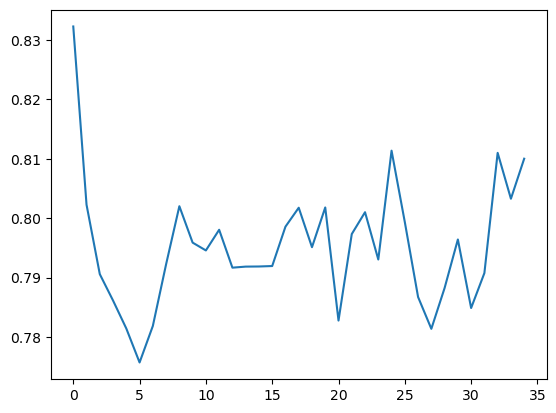

In [4]:
# V1
remove_thread_env_var()
times = []
start = time.time()
for i in range(NB_LOOPS):
    s_pinv = time.time()
    time_test.useless_function(1)
    e_pinv = time.time()
    times.append(e_pinv - s_pinv)
end = time.time()
print(f"Total time: {round(end - start, 2)} s (avg time per pinv: {round(np.mean(times), 4)}) s")
plt.plot(times)

In [7]:
# V2 apply
remove_thread_env_var()
def v2(nb_processes):
    start = time.time()
    pool = multiprocessing.Pool(nb_processes)
    outputs = [pool.apply(time_test.useless_function, (i + 1,)) for i in range(max_lag + 1)]
    end = time.time()
    print(f"{nb_processes} processes => Total time: {round(end - start, 2)} s [cpu: {round(100 * psutil.getloadavg()[0] / psutil.cpu_count(), 2)} % last minute]")

for nb_processes in [1, 2, 8]:
    v2(nb_processes)

1 processes => Total time: 51.64 s [cpu: 35.11 % last minute]
2 processes => Total time: 50.46 s [cpu: 33.25 % last minute]
8 processes => Total time: 51.91 s [cpu: 42.71 % last minute]


In [22]:
# V2 map
remove_thread_env_var()
def v2(nb_processes):
    start = time.time()
    all_x = [1 for _ in range(NB_LOOPS)]
    pool = multiprocessing.Pool(nb_processes)
    outputs = pool.map(time_test.useless_function, all_x)
    end = time.time()
    print(f"{nb_processes} processes => Total time: {round(end - start, 2)} s [cpu: {round(100 * psutil.getloadavg()[0] / psutil.cpu_count(), 2)} % last minute]")

for nb_processes in [1, 2, 8]:
    v2(nb_processes)

1 processes => Total time: 29.37 s [cpu: 38.68 % last minute]
2 processes => Total time: 18.43 s [cpu: 40.37 % last minute]
8 processes => Total time: 11.47 s [cpu: 62.99 % last minute]


In [14]:
# V3
importlib.reload(time_test)
remove_thread_env_var()

def v3(nb_processes):
    # fig, axe = plt.subplots(1, 1, figsize=(6, 3))
    start = time.time()
    nb_task_per_process = NB_LOOPS // nb_processes
    remaining_task = NB_LOOPS - nb_task_per_process * nb_processes

    indices = [[1 for _ in range(nb_task_per_process)] for _ in range(nb_processes)]
    for indice in indices:
        if (remaining_task > 0):
            indice.append(1)
            remaining_task -= 1
        else:
            break
    assert(sum([len(l) for l in indices]) == NB_LOOPS)

    processes = []
    for i in range(nb_processes):
        p = time_test.ProcessTest(indices[i])
        p.start()
        processes.append(p)

    total = 0
    means = []
    for p in processes:
        p.join()
        times = [p.times_process.get() for _ in range(len(p.indices))]
        total += sum(times)
        means.append(np.mean(times))
    #     axe.plot(times, label=f"{p.id} (avg: {round(np.mean(times), 2)} s)")
        
    # plt.legend()
    # plt.plot()

    end = time.time()
    print(f"{nb_processes} processes => Total time: {round(end - start, 2)} s (avg time per function: {round(np.mean(means), 2)} s) [cpu: {round(100 * psutil.getloadavg()[0] / psutil.cpu_count(), 2)} % last minute]")

for nb_processes in [1, 2, 4, 8]:
    v3(nb_processes)

1 processes => Total time: 28.43 s (avg time per function: 0.8 s) [cpu: 21.64 % last minute]
2 processes => Total time: 14.94 s (avg time per function: 0.79 s) [cpu: 26.91 % last minute]
4 processes => Total time: 9.69 s (avg time per function: 1.0 s) [cpu: 29.75 % last minute]
8 processes => Total time: 9.68 s (avg time per function: 1.84 s) [cpu: 99.56 % last minute]


In [17]:
def compute_func_for_each_core(indice):
    """ Work done by each core, specified by this function and the input """
    times = []
    for _ in indice:
        s = time.time()
        time_test.useless_function(1)
        e = time.time()
        times.append(e - s)
        # print(f"Time: {round(e - s, 4)} s")
    return times

def v4(nb_processes):
    # fig, axe = plt.subplots(1, 1, figsize=(6, 3))
    start = time.time()
    nb_task_per_process = NB_LOOPS // nb_processes
    remaining_task = NB_LOOPS - nb_task_per_process * nb_processes

    indices = [[1 for _ in range(nb_task_per_process)] for _ in range(nb_processes)]
    for indice in indices:
        if (remaining_task > 0):
            indice.append(1)
            remaining_task -= 1
        else:
            break
    assert(sum([len(l) for l in indices]) == NB_LOOPS)

    joblib_rets = Parallel(n_jobs=nb_processes)(
        delayed(compute_func_for_each_core)(indice) for indice in indices
    )

    total = 0
    means = []
    for i, times in enumerate(joblib_rets):
        total += sum(times)
        means.append(np.mean(times))
        # axe.plot(times, label=f"{i + 1} (mean: {round(np.mean(times), 2)})")

    end = time.time()

    # plt.legend()
    # plt.plot()
    print(f"{nb_processes} processes => Total time: {round(end - start, 2)} s (avg time per function: {round(np.mean(means), 2)} s) [cpu: {round(100 * psutil.getloadavg()[0] / psutil.cpu_count(), 2)} % last minute]")

for nb_processes in [1, 2, 4, 8]:
    v4(nb_processes)

1 processes => Total time: 27.62 s (avg time per function: 0.79 s) [cpu: 31.07 % last minute]
2 processes => Total time: 14.42 s (avg time per function: 0.79 s) [cpu: 30.64 % last minute]
4 processes => Total time: 9.56 s (avg time per function: 1.0 s) [cpu: 43.46 % last minute]
8 processes => Total time: 9.36 s (avg time per function: 1.83 s) [cpu: 54.07 % last minute]
